In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import healpy
from icecube import icetray, dataclasses, dataio, recclasses

In [2]:
# file provided by Jaun-Carlos (plus printing the keys for easy view)
# Load in the data file (contains SYBILL 2.3d data)
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")
print(list(d.keys()))

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'cogx', 'cogy', 'cogz', 'logMuE', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'GaisserH4a', 'reco_energy']


In [3]:
# set up quality cut for professional data
qual_cut = (d['zenith'] > 0.002) * (d['zenith'] < (np.pi - 0.002)) * (d['nchannel'] >= 10) * (d['isgoodllh'])
# set up bin cut
bin_cut = np.logical_and(d['reco_energy'] > 4, d['reco_energy'] < 8)

In [4]:
# weighted quantiles function used to calculate the median rigidity bin
def weighted_quantiles(values, weights, quantiles=0.5):
    if len(values) == 0:
        return 0
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [5]:
# functions to calculate Z value per event, save to array, then take the log10 of the array.
#define a function to go from PDG code to Z
def _get_charge(ptype):
    if ptype<1000020040:
        return 1
    else:
        remainder = int(ptype)%1000000000
        remainder -= remainder%1000
        
        return remainder/10000
    
#turn it into a vectorized function (for speed)
get_charge = np.vectorize(_get_charge)

#example of usage
zarray = get_charge(d['type'])

# create log10(z) array for later cells
lza = np.log10(zarray)

In [7]:
# set up compositional cuts to separate data by composition
pcut = d['type'] == 2212
Hecut = d['type'] == 1.00002004e+09
Ncut = d['type'] == 1.000070140e+09
Alcut = d['type'] == 1.00013027e+09
Fecut =  d['type'] == 1.00026056e+09

In [14]:
# set up dictionaries for later cells
# set up compositional cuts to separate data by composition
CCUT={
    'proton': d['type'] == 2212,
    'helium': d['type'] == 1.00002004e+09,
    'nitrogen': d['type'] == 1.000070140e+09,
    'aluminum': d['type'] == 1.00013027e+09,
    'iron': d['type'] == 1.00026056e+09
}
# Bins sets up energy bin tier cuts
BINS={
'4.125': np.logical_and(d['reco_energy'] > 4, d['reco_energy'] < 4.25),
'4.375': np.logical_and(d['reco_energy'] > 4.25, d['reco_energy'] < 4.5),
'4.625': np.logical_and(d['reco_energy'] > 4.5, d['reco_energy'] < 4.75),
'4.875': np.logical_and(d['reco_energy'] > 4.75, d['reco_energy'] < 5),
'5.125': np.logical_and(d['reco_energy'] > 5, d['reco_energy'] < 5.25),
'5.375': np.logical_and(d['reco_energy'] > 5.25, d['reco_energy'] < 5.5),
'5.75': np.logical_and(d['reco_energy'] > 5.5, d['reco_energy'] < 6),
'6.25': np.logical_and(d['reco_energy'] > 6, d['reco_energy'] < 6.5), 
'7.25': np.logical_and(d['reco_energy'] > 6.5, d['reco_energy'] < 8)
}

IC_COMPS = {
    'proton': pcut,
    'helium': Hecut,
    'nitrogen': Ncut,
    'aluminum': Alcut,
    'iron': Fecut
}

Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'oxygen': 8,
    'aluminum': 13,
    'iron': 26
}

In [10]:
# Calculate IceCube rigidity - mc_energy is not in log10
ic_rigidity = np.log10(d['mc_energy']) - 3
for comp, comp_cut in IC_COMPS.items():
    ic_rigidity[comp_cut] -= np.log10(Z[comp])

# Calculate median rigidity - note BINS are the IceCube BINS and comes from reco_energy.ipynb
ic_median_rigidity = []
for cut in BINS.values():
    combined_cut = cut * qual_cut
    
    ic_median_rigidity.append(weighted_quantiles(ic_rigidity[combined_cut], d['GaisserH4a'][combined_cut]))

print(ic_median_rigidity)

[1.0218638863006397, 1.2499663428707093, 1.4602289658373888, 1.6652357353887455, 1.8664315721735036, 1.9954148041517508, 2.171026513125118, 2.6410762854333925, 3.052710180267395]


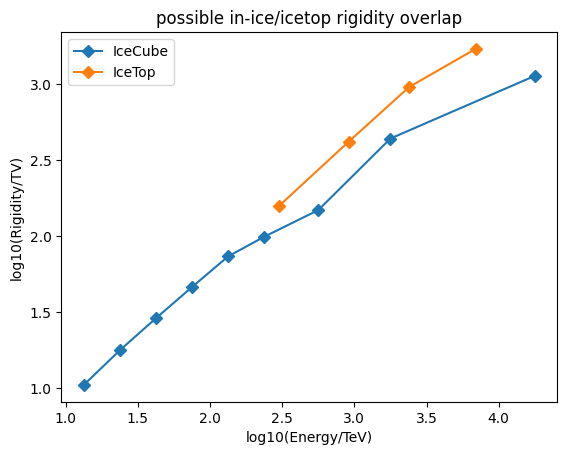

In [13]:
# Little cell that creates a line plot to compare in-ice and icetop median rigidity
ic_median_rigidity
x=[float(key)-3 for key in BINS.keys()]
ITmedArr=[2.2,2.62,2.98,3.23]
ITX=[2.48,2.96,3.38,3.84]
plt.plot(x, ic_median_rigidity, color='C0', label='IceCube', marker='D')
plt.plot(ITX, ITmedArr, color='C1', label='IceTop', marker='D')
plt.xlabel('log10(Energy/TeV)')
plt.ylabel('log10(Rigidity/TV)')
plt.title('possible in-ice/icetop rigidity overlap')
plt.legend()